In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import csv

## Import Data

In [2]:
train = pd.read_csv('C:\Users\Matthew\PycharmProjects\\train.csv')
test = pd.read_csv('C:\Users\Matthew\PycharmProjects\\test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Missing Values

In [3]:
print 'Nulls in Training Set\n'
print(train.isnull().sum())
print '\n\nNulls in Test Set\n'
print(test.isnull().sum())

Nulls in Training Set

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Nulls in Test Set

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## Data Visualization

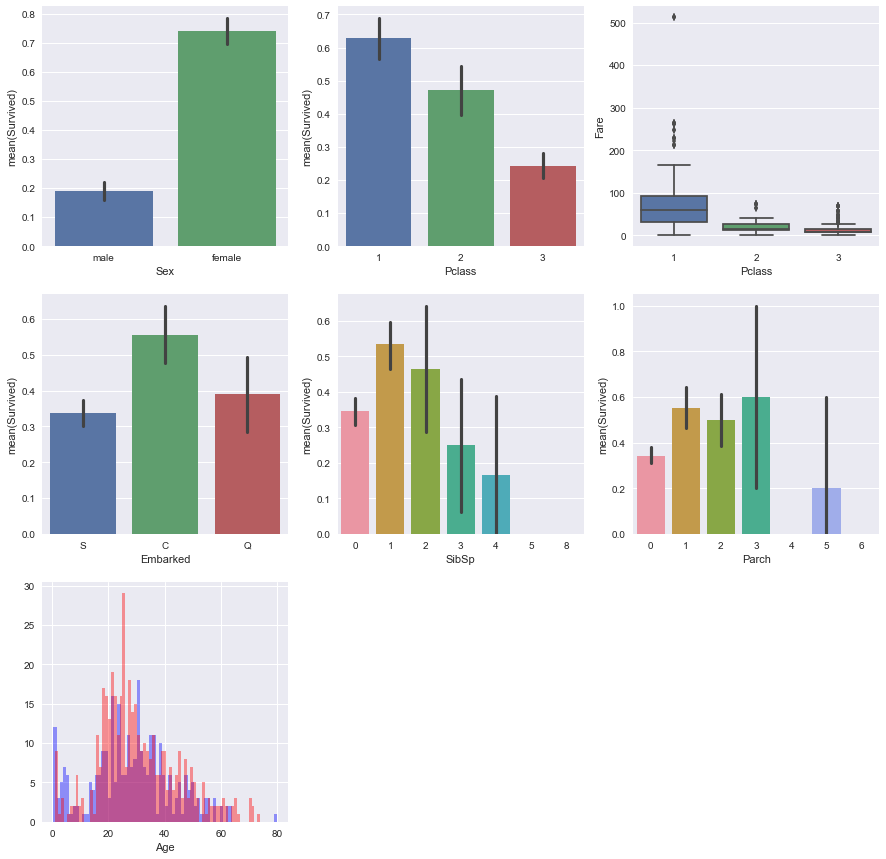

In [4]:
plt.figure(figsize=[15,15])
plt.subplot(331)
sns.barplot(x="Sex", y="Survived", data=train);
plt.subplot(332)
sns.barplot(x="Pclass", y="Survived", data=train);
plt.subplot(333)
sns.boxplot(x="Pclass", y="Fare", data=train);
plt.subplot(334)
sns.barplot(x="Embarked", y="Survived", data=train);
plt.subplot(335)
sns.barplot(x="SibSp", y="Survived", data=train);
plt.subplot(336)
sns.barplot(x="Parch", y="Survived", data=train);
plt.subplot(337)
alive = train[train['Survived']==1]
dead = train[train['Survived']==0]
sns.distplot(alive['Age'].dropna(), bins=70, kde=False, color="blue")
sns.distplot(dead['Age'].dropna(), bins=70, kde=False, color="red")
plt.show()

Takeaways from above:
- Sex: If you are a woman you have a higher chance of survival.
- Class: Higher status classes have a greater chance of survival.
- Fare: There is some association between fare and class, implying a similar relationship to survival for fare price like class.
- Embarked: Surprisingly those who embarked at "C" have a higher survival rate, but there could be a correlation with other variables.
- SibSP and Parch: Intermediate values for both increase the odds of survival.
- Age: Those who are younger have a greater chance of survival.

## Data Transformation

In [5]:
def cabin_manipulator(data):
    data['Cabin'] = data.Cabin.fillna('N')
    data['Cabin'] = data['Cabin'].apply(lambda x: x[0])  
    return data
    
def fare_manipulator(data):
    fare = data['Fare'].describe()
    data['Fare'] = data.Fare.fillna(-0.5)
    bins = (-1, 0, fare['25%'], fare['50%'], fare['75%'], 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(data.Fare, bins, labels=group_names)
    data.Fare = categories
    return data
    
def age_manipulator(data):
    data['Age'] = data.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 30, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Yound Adult', 'Adult', 'Senior']
    categories = pd.cut(data.Age, bins, labels=group_names)
    data['Age'] = categories
    return data

def data_manipulator(data):
    data = cabin_manipulator(data)
    data = fare_manipulator(data)
    data = age_manipulator(data)
    #data['Embarked'].replace(['C', 'Q', 'S'], [0, 1, 2], inplace=True)
    features = ['Sex', 'Age', 'Fare', 'Cabin', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(data[feature])
        data[feature] = le.transform(data[feature])    
    x = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']]
    return x

X = data_manipulator(train)
y = train.Survived
X_kaggle_test = data_manipulator(test)
print X.head()

   Pclass  Sex  Age  SibSp  Parch  Fare  Cabin  Embarked
0       3    1    6      1      0     0      7         3
1       1    0    0      1      0     3      2         1
2       3    0    6      0      0     1      7         3
3       1    0    0      1      0     3      2         3
4       3    1    0      0      0     1      7         3


C:\Users\Matthew\Anaconda3\envs\py2.7\lib\site-packages\numpy\lib\arraysetops.py:216: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
C:\Users\Matthew\Anaconda3\envs\py2.7\lib\site-packages\numpy\lib\arraysetops.py:275: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


## Null Accuracy

In [6]:
Null_Accuracy = max(y.mean(), 1 - y.mean())
print 'Null Accuracy %f' % Null_Accuracy

Null Accuracy 0.616162


The null accuracy being 61.6% gives a benchmark of how well the estimator performs since an estimator that predicts everyone dying would get an accuracy around that of the null, assuming that the training set is representative of the entire population.

## Logistic Regression

In [7]:
log_reg = LogisticRegression()
lr_accuracy = cross_val_score(log_reg, X, y, cv=10, scoring='accuracy').mean()
print 'Accuracy score of Logistic Regression Mode: %f' % lr_accuracy

Accuracy score of Logistic Regression Mode: 0.790106


Accuracy Score: 0.834080717489


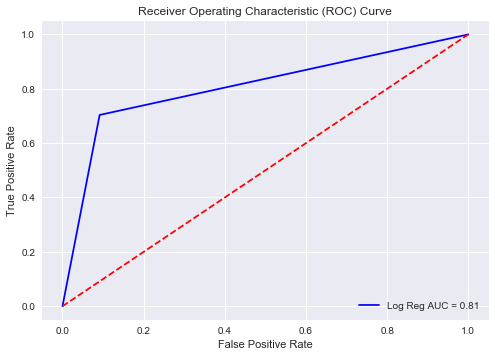

In [8]:
from sklearn.metrics import roc_curve, auc

log_reg = LogisticRegression()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=6)
log_reg.fit(Xtrain, ytrain)
ypredtest = log_reg.predict(Xtest)
print('Accuracy Score: {0}'.format(metrics.accuracy_score(ytest, ypredtest)))
fpr, tpr, thresholds = roc_curve(ytest, ypredtest, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label='Log Reg AUC = %0.2f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

The high accuracy score here in addition to the lower one obtained due to a 10 fold cross validation above indicates that there is relatively high variability in the accuracy of the estimator depending on what data it uses to train.

Best accuracy score: 0.793490460157
Best params: {'C': 0.5}


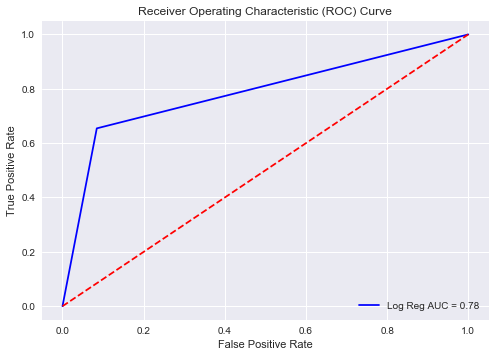

In [9]:
param_grid = {'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 100, 1000]}
clf = GridSearchCV(log_reg, param_grid, cv=10, scoring='accuracy')
clf.fit(X, y)
print('Best accuracy score: {0}'.format(clf.best_score_))
print('Best params: {0}'.format(clf.best_params_))

random_state_range = range(1, 11)

log_reg = clf.best_estimator_
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=6)
log_reg.fit(Xtrain, ytrain)
ypredtest = log_reg.predict(Xtest)
fpr, tpr, thresholds = roc_curve(ytest, ypredtest, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='Log Reg AUC = %0.2f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

## K-Nearest Neighbors

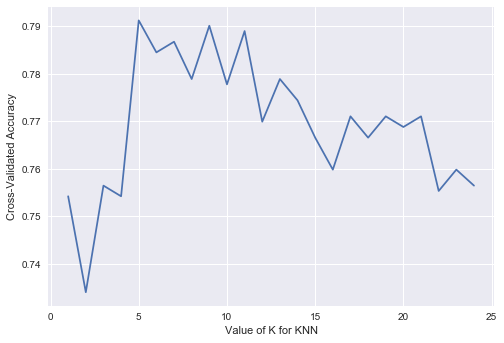

Best accuracy score: 0.791246 | Best K value: 5


In [10]:
knn = KNeighborsClassifier()
k_range = range(1, 25)
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid=param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)
grid_mean_scores = [result for result in grid.cv_results_['mean_test_score']]
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()
best_K = grid.best_params_['n_neighbors']
print 'Best accuracy score: %f | Best K value: %d' % (grid.best_score_, best_K)

From the figure above, it seems that a KNN classifier with K neighbors value of 5 has the best bias-variance trade-off, where lower K values have increasing bias and higher K values have increasing variance. This increase of bias for lower K values is due to the model overfitting the data by learning how to classify the the training data perfectly. As such, this makes it a poor model for generalizing to new data. For models with higher values of K, the bias is reduced, but eventually the model becomes too complex to where it too fails to generalize to new data. 

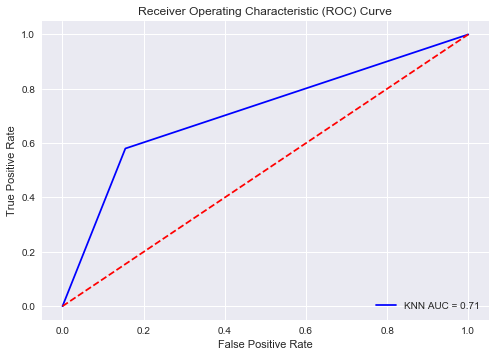

In [11]:
best_knn = grid.best_estimator_
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=6)
best_knn.fit(Xtrain, ytrain)
ypredtest = best_knn.predict(Xtest)
fpr, tpr, thresholds = roc_curve(ytest, ypredtest, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='KNN AUC = %0.2f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

While KNN has a comprable accuracy score, the AUC score is significantly smaller than those obtained through logistic regression. This indicates worse accuracy at identifying survivors of the Titanic.

## Random Forest

In [12]:
rf = RandomForestClassifier(n_estimators=200)

param_dist = { 'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 2, 4, 6, 8], 
              'max_depth' : [3, 6, 9],
              'min_samples_split' : [2, 4, 6, 8],
              'min_samples_leaf' : [1, 2, 4, 8, 16]
             }

random_grid = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy')
random_grid.fit(X,y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'max_features': ['auto', 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 8], 'criterion': ['gini', 'entropy'], 'max_depth': [3, 6, 9], 'min_samples_leaf': [1, 2, 4, 8, 16]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

The code above runs a cross validated randomized grid search. This means that there are n_iter possible combinations of parameters tested and the combination with the highest scoring accuracy over a 5-fold cross validation is the one chosen as the best estimator. The best estimator, with increased n_estimators, will then be used to predict whether the passengers with unknown fates on the Titanic lived or died. Based on the param_dist, there are 2x5x3x4x5=600 total parameter combinations available. If a subset was not chosen, running cross validation on such a high number of parameter combinations would take a long time.

In [13]:
print 'Best: Accuracy Score: %f' %random_grid.best_score_
print '\nBest Estimator: {}'.format(random_grid.best_estimator_)

Best: Accuracy Score: 0.830527

Best Estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


## Train Best Estimator on Full Training Set and Test

In [14]:
best = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

best.fit(X, y)
y_pred = best.predict(X_kaggle_test)

# Makes the csv file to submit on Kaggle
ans_length = range(0, len(y_pred))
f = open('titanic.csv', 'wb')
try:
    writer = csv.writer(f)
    writer.writerow(('PassengerId', 'Survived'))
    for i in ans_length:
        writer.writerow((test['PassengerId'][i], y_pred[i]))
finally:
    f.close()